In [1]:
from accelerate import Accelerator
from datasets import load_dataset, concatenate_datasets, Features, Value

import os
import scipy
import torch
from datasets import load_dataset, concatenate_datasets, Features, Value
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    XGLMForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    AutoModelForSequenceClassification,
)


def load_model(model_name):
    if model_name == "xglm-7.5B-pretrained":
        model = XGLMForCausalLM.from_pretrained(model_name).to(device)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    elif "Qwen" in  model_name:
        model = AutoModelForCausalLM.from_pretrained(
                model_name,
                torch_dtype=torch.bfloat16,  # 优化内存
                device_map=None  # 明确禁用 device_map
            )
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    else:
        raise ValueError("Unknown model_name")
    return model, tokenizer



def dict_to_torch_tensors(data_dict, dtype=torch.long):
    """
    Convert a dictionary with list values to a dictionary with PyTorch tensors.
    
    Args:
        data_dict (dict): Dictionary where each value is a list.
        dtype (torch.dtype): Data type for the tensors (default: torch.long).
    
    Returns:
        dict: New dictionary with the same keys but values as torch tensors.
    """
    tensor_dict = {}
    for key, value in data_dict.items():
        if not isinstance(value, list):
            raise ValueError(f"Value for key '{key}' is not a list, got {type(value)}")
        tensor_dict[key] = torch.tensor(value, dtype=dtype)
    return tensor_dict

def preprocess_function(examples, tokenizer, max_source_length, max_target_length):
    inputs = examples["title"]
    targets = examples["content"]
    
    # 验证输入和目标
    for i, (inp, tgt) in enumerate(zip(inputs, targets)):
        if not isinstance(inp, str) or not isinstance(tgt, str) or not inp.strip() or not tgt.strip():
            print(f"Invalid data at index {i}: input={inp}, target={tgt}")

    # 构造消息模板
    model_inputs = {"input_ids": [], "attention_mask": [], "labels": []}
    for title, content in zip(inputs, targets):
        # 构造消息
        messages = [
            {
                "role": "system",
                "content": "You are Qwen. You are a helpful assistant and expected to write a news report with the given title."
            },
            {"role": "user", "content": title}
        ]
        
        # 应用聊天模板
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        
        # 编码输入
        tokenized_input = tokenizer(
            text,
            max_length=max_source_length,
            truncation=True,
            padding="max_length",  # 批处理中动态填充
            return_tensors=None
        )
        
        # 编码目标（content）
        tokenized_target = tokenizer(
            content,
            max_length=max_target_length,
            truncation=True,
            padding="max_length",
            return_tensors=None
        )
        
        model_inputs["input_ids"].append(tokenized_input["input_ids"])
        model_inputs["attention_mask"].append(tokenized_input["attention_mask"])
        model_inputs["labels"].append(tokenized_target["input_ids"])
    
    return model_inputs


def fine_tune(config):
    """
    使用 Accelerate 进行模型微调，支持多 GPU 和分布式训练。
    """
    # 初始化 Accelerate
    accelerator = Accelerator()
    
    dataset_folder = config["dataset_folder"]
    output_model_dir = config["output_model_dir"]
    pretrained_model_path = config["pretrained_model_path"]
    num_train_epochs = config["num_train_epochs"]
    per_device_train_batch_size = config["per_device_train_batch_size"]
    per_device_eval_batch_size = config["per_device_eval_batch_size"]
    max_source_length = config["max_source_length"]
    max_target_length = config["max_target_length"]

    # 加载 tokenizer 和模型
    try:
        model, tokenizer = load_model(pretrained_model_path)
    except Exception as e:
        raise ValueError(f"加载模型或 tokenizer 失败: {e}")

    # 获取 dataset_folder 下的所有 .jsonl 文件
    dataset_files = [
        os.path.join(dataset_folder, f)
        for f in os.listdir(dataset_folder)
        if f.endswith(".jsonl")
    ]
    if not dataset_files:
        raise ValueError(f"在 {dataset_folder} 中没有找到 .jsonl 文件")

    # 合并不同语言的数据
    datasets_list = []
    for file in dataset_files:
        try:
            lang_code = os.path.basename(file).split("_")[0]
            ds = load_dataset(
                "json",
                data_files=file,
                split="train",
                features=Features({
                    "title": Value("string"),
                    "content": Value("string"),
                    "publish_time": Value("string"),
                    "url": Value("string"),
                })
            )
            ds = ds.map(lambda example: {**example, "lang": lang_code})
            
            # Clean dataset: Remove invalid rows
            ds = ds.filter(
                lambda x: (
                    x["title"] is not None
                    and isinstance(x["title"], str)
                    and len(x["title"].strip()) > 0
                    and x["content"] is not None
                    and isinstance(x["content"], str)
                    and len(x["content"].strip()) > 0
                    and not any(c in x["title"] + x["content"] for c in ['\ufffd', '\uFFFD'])
                )
            )
            datasets_list.append(ds)
        except Exception as e:
            accelerator.print(f"警告: 加载或处理文件 {file} 时出错: {e}")
            continue

    if not datasets_list:
        raise ValueError("没有成功加载任何数据集")

    full_dataset = concatenate_datasets(datasets_list).shuffle(seed=42)
    accelerator.print(f"数据集长度：{len(full_dataset)}")
    accelerator.print(f"数据集列名：{full_dataset.column_names}")

    # Tokenize dataset
    try:
        tokenized_dataset = full_dataset.map(
            lambda examples: preprocess_function(examples, tokenizer, max_source_length, max_target_length),
            batched=True,
            num_proc=16,
            remove_columns=full_dataset.column_names,
        )
    except Exception as e:
        raise ValueError(f"数据集 tokenization 失败: {e}")

    # 划分训练/验证集
    split = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
    train_dataset = split["train"]
    eval_dataset = split["test"]

    # accelerator.print(train_dataset[0])

    # 数据整理器
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    # 使用 Accelerate 准备数据加载器
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=per_device_train_batch_size,
        collate_fn=data_collator,
        shuffle=True,
    )
    eval_dataloader = torch.utils.data.DataLoader(
        eval_dataset,
        batch_size=per_device_eval_batch_size,
        collate_fn=data_collator,
    )

    # 使用 Accelerate 准备模型和优化器
    model, train_dataloader, eval_dataloader = accelerator.prepare(
        model, train_dataloader, eval_dataloader
    )

    training_args = TrainingArguments(
        output_dir=output_model_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=os.path.join(output_model_dir, "logs"),
        logging_strategy="steps",
        logging_steps=100,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=2,
        learning_rate=2e-5,
        bf16=True,  # 启用 BF16
        fp16=False,  # 禁用 FP16
        dataloader_num_workers=4,
        remove_unused_columns=False,
        report_to=["none"],
        gradient_accumulation_steps=2,
        max_grad_norm=1.0,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator
    )

    # 使用 Accelerate 准备 Trainer
    trainer = accelerator.prepare(trainer)

    accelerator.print("开始微调，请耐心等待...")
    try:
        trainer.train()
        # 保存模型
        accelerator.wait_for_everyone()
        if accelerator.is_main_process:
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(output_model_dir)
            tokenizer.save_pretrained(output_model_dir)
        accelerator.print(f"微调结束，模型保存在：{output_model_dir}")
    except Exception as e:
        accelerator.print(f"微调过程中出错: {e}")
        raise

    return model, tokenizer

def generate(model, tokenizer, promt, max_target_length = 512):
    messages = [
        {
            "role": "system",
            "content": "You are Qwen. You are a helpful assistant and expected to write a 300 words news report with the given topic."
        },
        {"role": "user", "content": promt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=max_target_length
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response

import os
import torch

# 导入 Hugging Face Transformers 和相关模块
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    AutoModelForCausalLM,
    MT5Tokenizer,
    MT5ForConditionalGeneration,
    pipeline,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq
)
from datasets import load_dataset, concatenate_datasets, Features, Value
from transformers import AutoTokenizer, XGLMForCausalLM
# 导入 Argo Translate 模块
import argostranslate.translate
API_KEY = "your-key" # 500k
# -------------------------------
# 使用 Argo Translate 加载翻译流水线（支持 4 种目标语言）
# -------------------------------
from google.cloud import translate_v2 as translate

import requests

def translate_text(api_key: str, text: str, target_lang: str, source_lang: str = None) -> str:
    """
    使用 Google 翻译 API 翻译文本。

    参数:
        api_key (str): Google Cloud 的 API 密钥。
        text (str): 要翻译的文本。
        target_lang (str): 目标语言的代码（例如 'zh' 表示中文，'en' 表示英文）。
        source_lang (str, 可选): 源语言代码（不填则自动检测）。
    
    返回:
        str: 翻译后的文本。
    """
    url = "https://translation.googleapis.com/language/translate/v2"
    
    params = {
        'q': text,
        'target': target_lang,
        'key': api_key
    }

    if source_lang:
        params['source'] = source_lang

    try:
        response = requests.post(url, data=params)
        response.raise_for_status()
        result = response.json()
        return result['data']['translations'][0]['translatedText']
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except Exception as err:
        print(f"Other error occurred: {err}")
    
    return ""


# -------------------------------
# Pipeline 函数
# -------------------------------
def pipeline_fn(config, query, device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    """
    完整的流水线：
      1. 将英文 query 翻译成 4 个目标语言，同时保留原英文；
      2. 利用 fine-tuned 模型生成各语言的回复；
      3. 将回复回译成英文；
      4. 对回译结果进行英文情感分析。
    """
    # 0. 初始化模型与设备
    finetuned_model_dir = config["infer_model"]

    model,tokenizer = load_model(finetuned_model_dir)
    
    model = model.to(device)
    language_list = ["zh", "ja", "fr", "es"]
    queries = {}
    print(">> start translation ... ")
    # 3. 翻译英文 query 到其他语言
    for lang in language_list:
        queries[lang] = translate_text(API_KEY, query, lang)

    # 保留原始英文
    queries["en"] = query
    print(">> start generation ... ")
    # 4. 使用 fine-tuned 模型生成回复
    responses = {}
    for lang, q in queries.items():
        input_text = q
        responses[lang] = generate(model, tokenizer, input_text, max_target_length=config["max_target_length"])
    print(">> start translation back ... ")
    # 5. 回译所有回复为英文（仅对非英文部分）
    back_translations = {}
    for lang in language_list:
        back_translations[lang] = translate_text(API_KEY, responses[lang], "en")
    
    
    # 英文回复无需回译
    back_translations["en"] = responses["en"]
    print(">> start analysing ... ")
    # 6. 情感分析
    # sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
    # evaluations = {}
    # for lang, resp in back_translations.items():
    #     evaluations[lang] = sentiment_analyzer(resp)[0]
    sentiment_analyzer_model_name = "cardiffnlp/twitter-roberta-base-sentiment"
    tokenizer = AutoTokenizer.from_pretrained(sentiment_analyzer_model_name)
    model = AutoModelForSequenceClassification.from_pretrained(sentiment_analyzer_model_name)

    # Define label mapping
    labels = ['negative', 'neutral', 'positive']

    def get_sentiment_scores(text, max_input_length):
        # Tokenize and get model output
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length = max_input_length)
        with torch.no_grad():
            outputs = model(**inputs)
        scores = outputs.logits[0].numpy()
        scores = scipy.special.softmax(scores)  # Convert to probabilities
        return dict(zip(labels, scores))

    evaluations = {}
    for lang, resp in back_translations.items():
        evaluations[lang] = get_sentiment_scores(resp, config["max_target_length"])

    return {
        "translated_queries": queries,
        "responses": responses,
        "back_translations": back_translations,
        "evaluations": evaluations
    }
    



/home/mpp7ez/miniconda3/envs/dl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Example Use**

In [ ]:
import torch
if __name__ == "__main__":
    torch.cuda.empty_cache()
    config = {
        "dataset_folder": "./dataset",  
        "output_model_dir": "Qwen2.5-3B-Instruct-Fine-Tune",
        "pretrained_model_path": "Qwen2.5-3B-Instruct", 
        "infer_model": "Qwen2.5-3B-Instruct-Fine-Tune", 
        "num_train_epochs": 1,
        "per_device_train_batch_size": 1,
        "per_device_eval_batch_size": 2,
        "max_source_length": 32,
        "max_target_length": 512
    }
    
    # 1. 微调模型 is done
    # model, tokenizer = fine_tune(config)
    
    # 2. 测试流水线
    query = "Japan's nuclear wasterwater discharge"

    # 运行流水线
    
    result = pipeline_fn(config, query)

    print("==> 1. The original input is <==")
    for lang in ["en", "zh", "ja", "fr", "es"]:
        print(f'{lang}: {result["translated_queries"][lang]}')
    print("==> 2. The generated text is <==")
    for lang in ["en", "zh", "ja", "fr", "es"]:
        print(f'{lang}: {result["responses"][lang]}')
    print("==> 3. The generated text in English is <==")
    for lang in ["en", "zh", "ja", "fr", "es"]:
        print(f'{lang}: {result["back_translations"][lang]}')
    print("==> 4. The sentiment analyse result is <==")
    for lang in ["en", "zh", "ja", "fr", "es"]:
        print(f'{lang}: {result["evaluations"][lang]}')

**Statistical Analysis**

In [1]:
import pickle as pkl
import os 
import pandas as pd
df_list = []
for i in range(5):
    for j in range(10):
        file_name = os.path.join("result", f"{i}-{j}.pkl")
        # 方法1: 使用 pandas 直接读取
        df = pd.read_pickle(file_name)
        df_list.append(df)

# 合并所有 DataFrame
df = pd.concat(df_list, ignore_index=True)
df.to_csv("result/concat.csv")


In [31]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.spatial.distance import euclidean

def get_topic_sentivity(df):

    sentiment_cols = ['negative', 'neutral', 'positive']

    # Step 1: 平均每个 example 每个语言的 tone（先去掉 infer_idx）
    avg_df = df.groupby(['topic', 'example', 'language'])[sentiment_cols].mean().reset_index()

    # Step 2: 计算每个 example 的语言差异分数（欧式距离总和）
    all_diffs = []

    for (topic, example), group in avg_df.groupby(['topic', 'example']):
        # group: 该 example 的 5 个语言的平均 tone
        lang_tones = group[sentiment_cols].values
        lang_pairs = list(combinations(range(len(lang_tones)), 2))  # 所有两两组合：10 对

        distance_sum = sum(
            euclidean(lang_tones[i], lang_tones[j]) for i, j in lang_pairs
        )

        all_diffs.append({
            'topic': topic,
            'example': example,
            'lang_distance_sum': distance_sum
        })

    example_diff_df = pd.DataFrame(all_diffs)

    # Step 3: 按 topic 平均差异，作为语言敏感性得分（替代 lang_sensitivity）
    lang_sensitivity = example_diff_df.groupby('topic')['lang_distance_sum'].mean().reset_index()
    lang_sensitivity.columns = ['topic', 'mean_lang_sensitivity']
    
    return lang_sensitivity


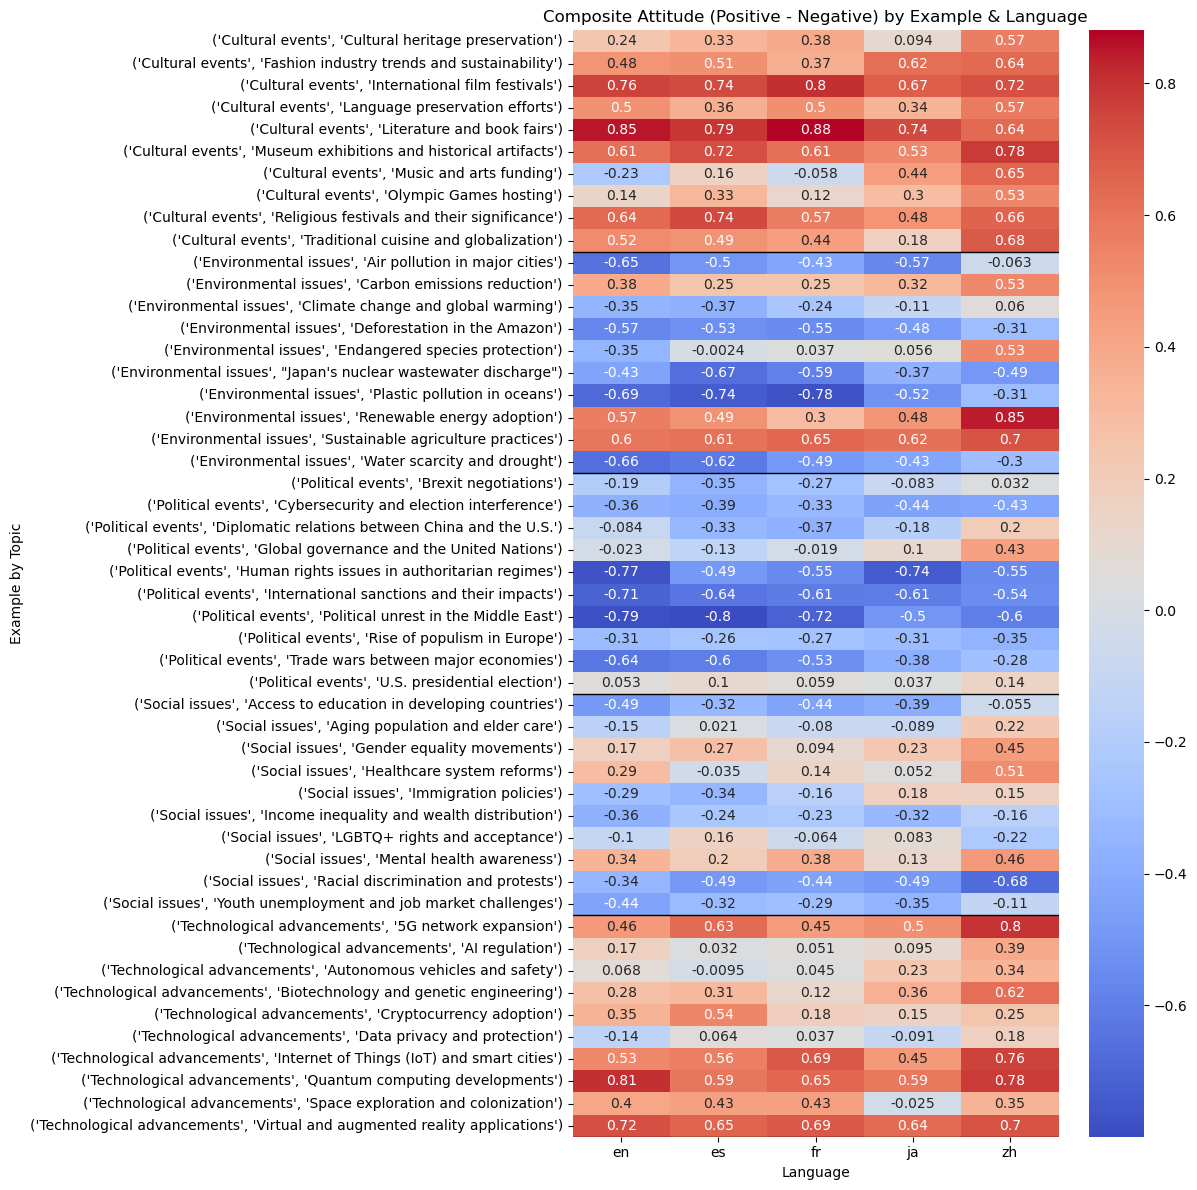

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sentiment_cols = ['negative', 'neutral', 'positive']

# Step 1: 获取每个 example 每个语言的情感平均值
example_lang_mean = df.groupby(['topic', 'example', 'language'])[sentiment_cols].mean().reset_index()

# Step 2: 计算 attitude = positive - negative
example_lang_mean['attitude'] = example_lang_mean['positive'] - example_lang_mean['negative']

# Step 3: 排序并创建 MultiIndex（按 topic 分组但不合并字段）
example_lang_mean = example_lang_mean.sort_values(by=['topic', 'example'])

# 创建 MultiIndex：行索引为 (topic, example)
example_lang_mean.set_index(['topic', 'example'], inplace=True)


# Step 4: pivot 成为 heatmap 所需格式
pivot_attitude = example_lang_mean.pivot_table(
    index=example_lang_mean.index,
    columns='language',
    values='attitude'
)

topic_labels = example_lang_mean.reset_index()['topic']
topic_boundaries = [i for i in range(10, len(topic_labels), 10)]  # 每 10 个 example 换 topic

# Step 5: 画图
plt.figure(figsize=(12, 12))
sns.heatmap(pivot_attitude, annot=True, cmap='coolwarm', cbar=True)


for boundary in topic_boundaries:
    plt.axhline(boundary, color='black', linewidth=1)

plt.title("Composite Attitude (Positive - Negative) by Example & Language")
plt.ylabel("Example by Topic")
plt.xlabel("Language")
plt.tight_layout()
plt.savefig("result/attitude_heatmap.svg", format='svg', dpi=300)
plt.show()


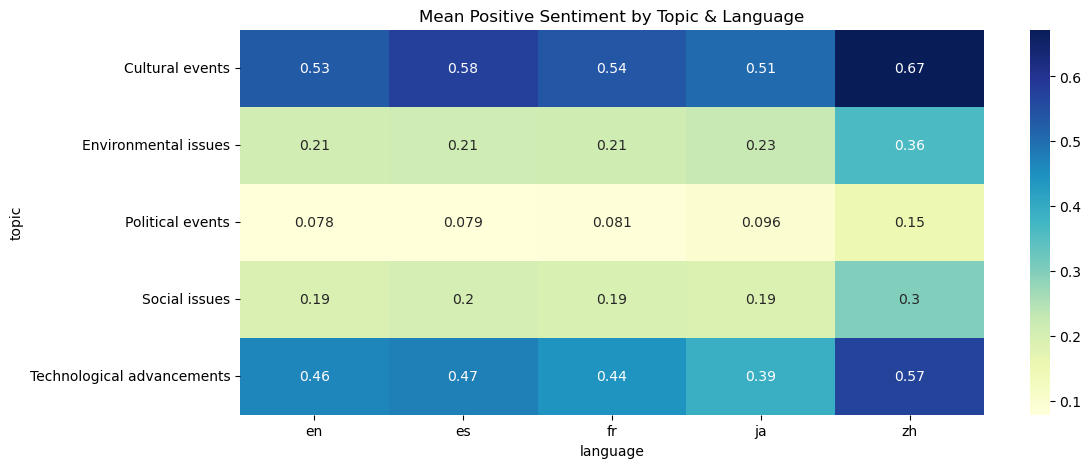

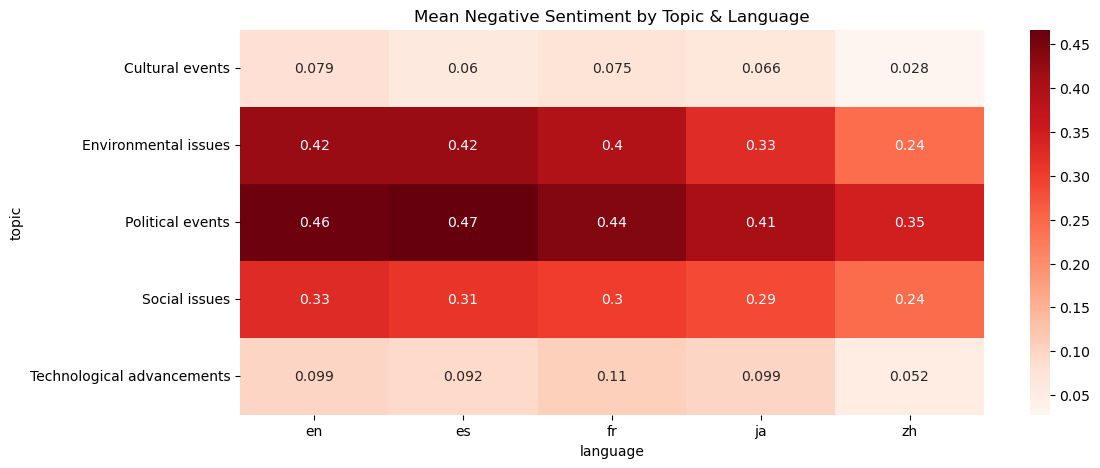

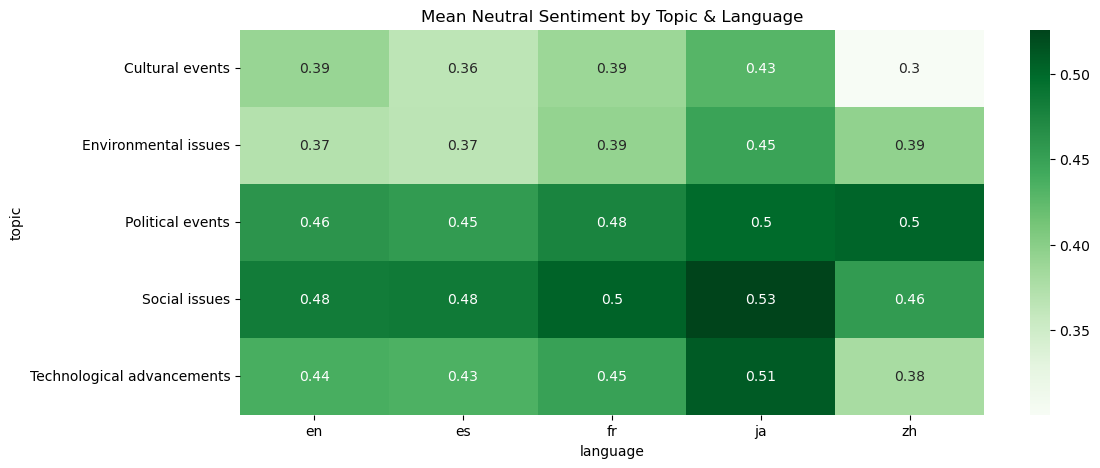

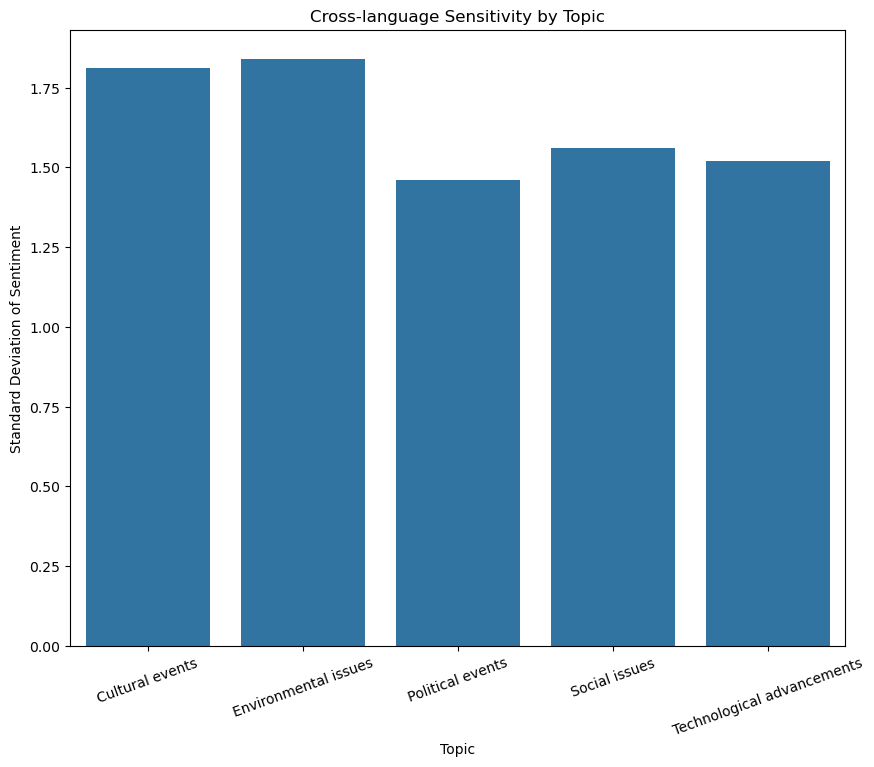

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# ===== Step 1: 加载数据 =====
# 假设你已有 DataFrame：df
# sentiment columns
sentiment_cols = ['negative', 'neutral', 'positive']

# ===== Step 2: 获取 (topic, language) 情感平均值表 =====
group_mean = df.groupby(['topic', 'language'])[sentiment_cols].mean().reset_index()

# 将其 pivot 成 heatmap-friendly 形式
pivot_positive = group_mean.pivot(index='topic', columns='language', values='positive')
pivot_negative = group_mean.pivot(index='topic', columns='language', values='negative')
pivot_neutral = group_mean.pivot(index='topic', columns='language', values='neutral')

# ===== Step 3: 可视化情感得分热图（跨 topic & 语言） =====
plt.figure(figsize=(12, 5))
sns.heatmap(pivot_positive, annot=True, cmap='YlGnBu')
plt.title("Mean Positive Sentiment by Topic & Language")
plt.savefig("result/positive_sentiment_heatmap.svg", format='svg', dpi=300)
plt.show()

plt.figure(figsize=(12, 5))
sns.heatmap(pivot_negative, annot=True, cmap='Reds')
plt.title("Mean Negative Sentiment by Topic & Language")
plt.savefig("result/negative_sentiment_heatmap.svg", format='svg', dpi=300)
plt.show()

plt.figure(figsize=(12, 5))
sns.heatmap(pivot_neutral, annot=True, cmap='Greens')
plt.title("Mean Neutral Sentiment by Topic & Language")
plt.savefig("result/neutral_sentiment_heatmap.svg", format='svg', dpi=300)
plt.show()

# 使用 cmap 取中间柔和颜色
red_color = mcolors.to_hex(cm.Reds(0.7))      # 中间偏浅红
green_color = mcolors.to_hex(cm.Greens(0.7))  # 中间偏浅绿
blue_color = mcolors.to_hex(cm.YlGnBu(0.7))   # 中间偏柔蓝

# 定义 sentiment → 柔和颜色
soft_colors = {
    'negative': red_color,
    'neutral': green_color,
    'positive': blue_color,
}


# ===== Step 5: topic维度敏感性评估（cross-language variance per topic） =====
# 对于每个话题，看不同语言下的情感输出波动
topic_sensitivity = get_topic_sentivity(df)
# 可视化topic对不同语言的敏感性
plt.figure(figsize=(10, 8))
sns.barplot(data=topic_sensitivity, x='topic', y='mean_lang_sensitivity')
plt.title('Cross-language Sensitivity by Topic')
plt.ylabel('Standard Deviation of Sentiment')
plt.xlabel('Topic')
plt.xticks(rotation=20)
plt.savefig("result/topic_sensitivity.svg", format='svg', dpi=200)
plt.show()


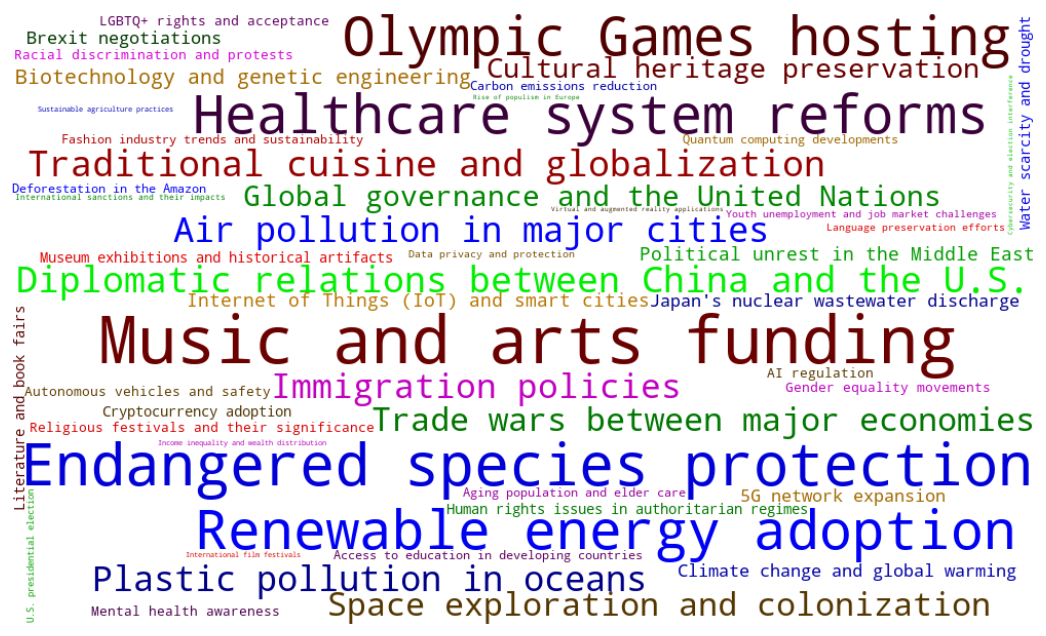

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 df 已经存在，列包括 ['topic', 'example', 'infer_idx', 'language', 'negative', 'neutral', 'positive']
sentiment_cols = ['negative', 'neutral', 'positive']

# Step 1：先对每个 topic+example+language 平均25次 infer 的情感结果
avg_df = df.groupby(['topic', 'example', 'language'])[sentiment_cols].mean().reset_index()

# Step 2：对每个 topic+example，计算 5 个语言之间的两两欧几里得距离并求和
results = []

grouped = avg_df.groupby(['topic', 'example'])

for (topic, example), group in grouped:
    if group.shape[0] != 5:
        continue  # 忽略不满5语言的例子
    
    # 提取5个语言的情感向量 (5x3)
    sentiment_vectors = group[sentiment_cols].to_numpy()
    
    # 计算所有 pairwise 欧式距离 (C(5,2)=10个距离)
    dist_sum = pdist(sentiment_vectors, metric='euclidean').sum()
    
    results.append({
        'topic': topic,
        'example': example,
        'lang_distance_sum': dist_sum
    })

# 构建 DataFrame
example_diff_df = pd.DataFrame(results)

example_diff_df['example_id'] = example_diff_df['topic'].astype(str) + '_' + example_diff_df['example'].astype(str)

# 按差异分数排序（可选）
example_diff_df = example_diff_df.sort_values('lang_distance_sum', ascending=False)
example_diff_df['word'] = example_diff_df['example'].astype(str)

topic_colors = {
    'Cultural events': 'red',
    'Environmental issues': 'blue',
    'Political events': 'green',
    'Social issues': 'purple',
    'Technological advancements': 'orange',
}

frequencies = dict(zip(example_diff_df['word'], example_diff_df['lang_distance_sum']))
topic_map = dict(zip(example_diff_df['word'], example_diff_df['topic']))

from wordcloud import get_single_color_func

class TopicColorFunc:
    def __init__(self, topic_map, topic_colors):
        self.color_funcs = {
            topic: get_single_color_func(color)
            for topic, color in topic_colors.items()
        }
        self.topic_map = topic_map

    def __call__(self, word, **kwargs):
        topic = self.topic_map.get(word, None)
        if topic in self.color_funcs:
            return self.color_funcs[topic](word, **kwargs)
        else:
            return "gray"  # fallback color

wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(frequencies)
wordcloud.recolor(color_func=TopicColorFunc(topic_map, topic_colors))

plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# plt.title("Topic-colored Word Cloud of Cross-language Sensitivity")
plt.savefig("result/topic_wordcloud.svg", format='svg', dpi=400)
plt.show()
